# SCALE tutorial

### Read alignment and peak calling

** We used Kundaje pipeline (https://github.com/kundajelab/atac_dnase_pipelines) for aligning pair ended reads to hg19 and removing duplicates as scABC (https://github.com/SUwonglab/scABC/) did **  
bds_scr [SCR_NAME] atac.bds -align -species hg19 -species_file [SPECIES_FILE_PATH] -nth [NUM_THREADS] -fastq1_1 [READ_PAIR1] -fastq1_2 [READ_PAIR2]

** The resulting bam files were merged using samtools. **  
samtools merge [AGGREGATE_BAM] *.trim.PE2SE.nodup.bam  

** The merged bam file was then used as input into MACS2 to call merged peaks for later analysis, using the Kundaje pipeline again.**  
bds_scr [SCR_NAME] atac.bds -species hg19 -species_file [SPECIES_FILE_PATH] -nth [NUM_THREADS] -se -filt_bam [AGGREGATE_BAM]


### Preprocessing
from scale.utils import sample_filter, peak_filter, cell_filter  
** We filtered peaks that presented in >= 10 cells with >= 2 reads by peak_filter function **  
data = peak_filter(data)    
** We filtered cells that >= number of peaks / 50 by cell_filter function **  
data = cell_filter(data)  
** Or combine peak_filter and cell_filter **  
data = sample_filter(data)

# Get Started from a scATAC-seq data matrix

## Running SCALE model 
e.g. SCALE -d data_matrix -k cluster_number -o output_dir  
** input:**  
data matrix

** output: **  
1. feature.txt 
2. cluster_assignments.txt
3. impute_data.txt
4. specific_peaks/ folder
5. model.pt

In [21]:
!SCALE -d ../data/data.txt -k 6 -e 1000


**********************************************************************
  SCALE: Single-Cell ATAC-seq Analysis via Latent feature Extraction
**********************************************************************

======== Parameters ========
Cell number: 391
Input_dim: 7602
n_centroids: 6
Epoch: 1000
Seed: 18

## Training Model ##
[Epoch  10] Loss: 920.470 lr: 0.0020
[Epoch  20] Loss: 860.525 lr: 0.0018
[Epoch  30] Loss: 833.875 lr: 0.0016
[Epoch  40] Loss: 816.981 lr: 0.0015
[Epoch  50] Loss: 790.948 lr: 0.0013
[Epoch  60] Loss: 780.299 lr: 0.0012
[Epoch  70] Loss: 784.853 lr: 0.0011
[Epoch  80] Loss: 779.270 lr: 0.0010
[Epoch  90] Loss: 772.970 lr: 0.0009
[Epoch 100] Loss: 765.978 lr: 0.0008
[Epoch 110] Loss: 777.822 lr: 0.0007
[Epoch 120] Loss: 765.202 lr: 0.0006
[Epoch 130] Loss: 758.798 lr: 0.0006
[Epoch 140] Loss: 766.184 lr: 0.0005
[Epoch 150] Loss: 754.977 lr: 0.0005
[Epoch 160] Loss: 754.023 lr: 0.0004
[Epoch 170] Loss: 751.410 lr: 0.0004
[Epoch 180] Loss: 746.332 lr: 0.0003
[

## Analysis workflow
1. visualization of latent feature embeddings
2. confusion matrix
3. data imputation analysis
4. cell type specific elements

In [1]:
import pandas as pd
import numpy as np

from scale.plot import *
from scale.utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

In [3]:
input_dir = '../data/'
out_dir = '../output/'

In [4]:
specific_peak_dir = out_dir + 'specific_peaks/'
feature_file = out_dir+'feature.txt'
assignments_file = out_dir+'cluster_assignments.txt'
impute_data_file = out_dir+'imputed_data.txt'

raw_data_file = input_dir + 'data.txt'
reference_file = input_dir + 'labels.txt'

In [5]:
raw_data = pd.read_csv(raw_data_file, sep='\t', index_col=0)
imputed_data = pd.read_csv(impute_data_file, sep='\t', index_col=0)

In [6]:
ref, classes = read_labels(reference_file)
assignments, assign_classes = read_labels(assignments_file)
_, assignments = cluster_acc(assignments, ref) # reassignment cluster

## 1. Feature embedding
different color representing ground truth cell types

In [7]:
feature = pd.read_csv(feature_file, sep='\t', index_col=0, header=None)

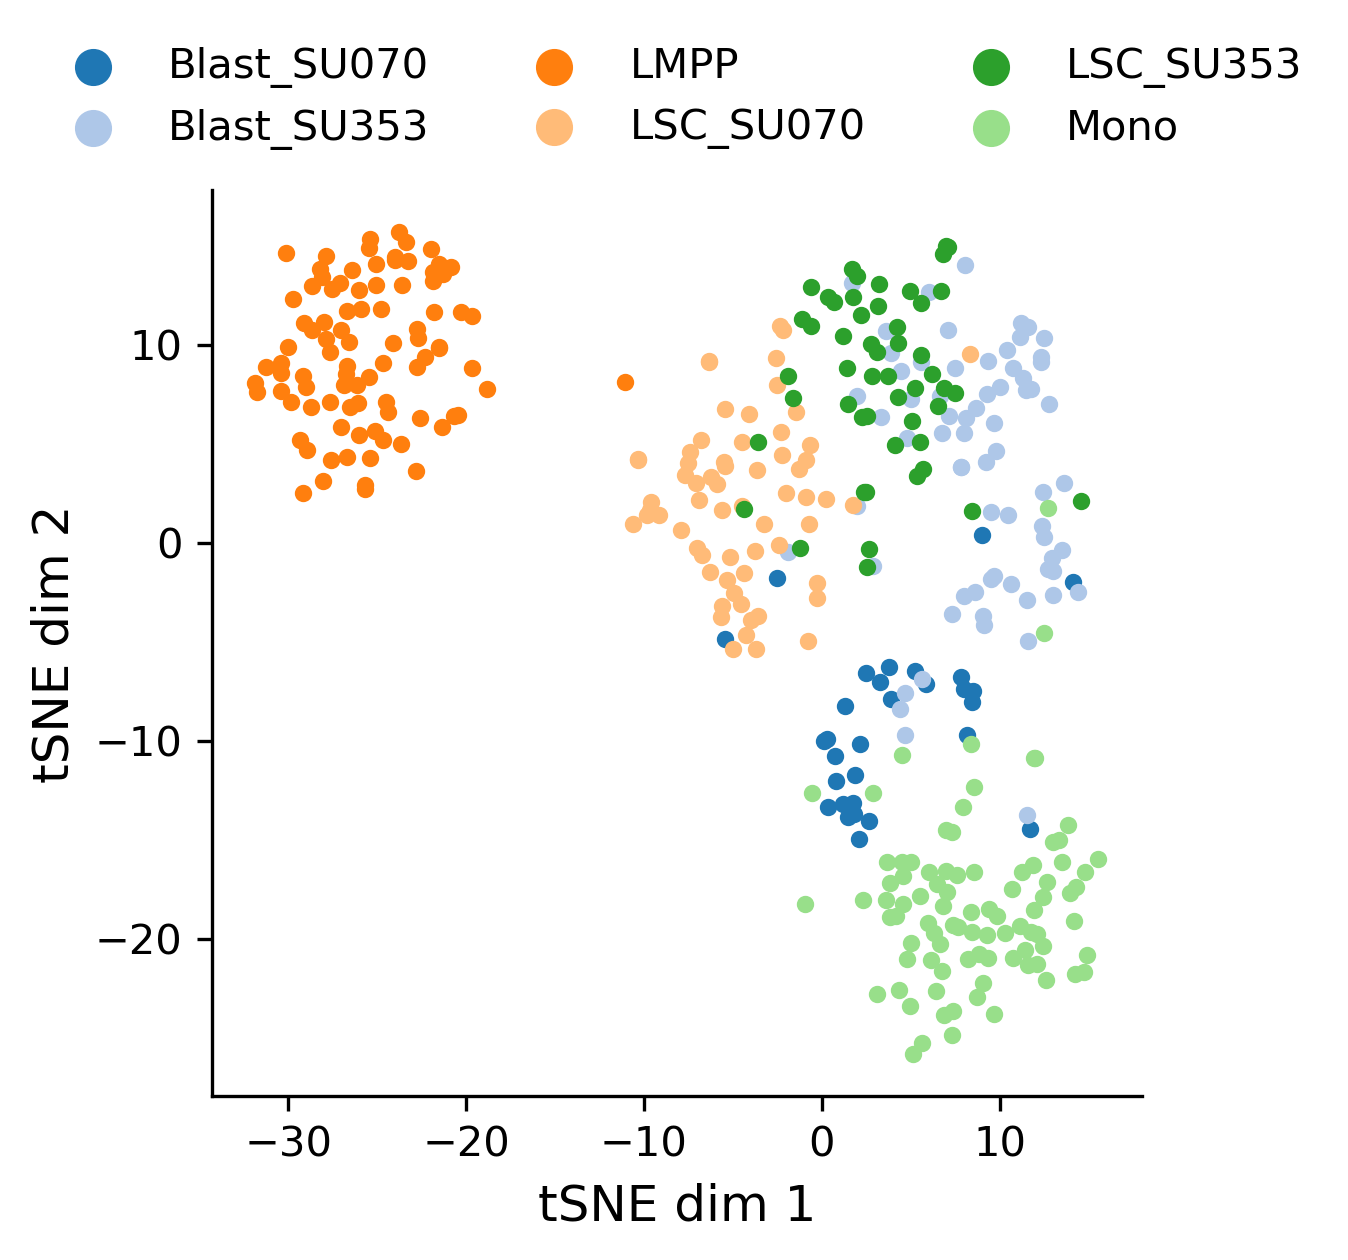

In [8]:
plot_embedding(feature, ref, classes, markersize=10, figsize=(4,4))

## 2. Confusion matrix 
cluster assignments compared with ground truth

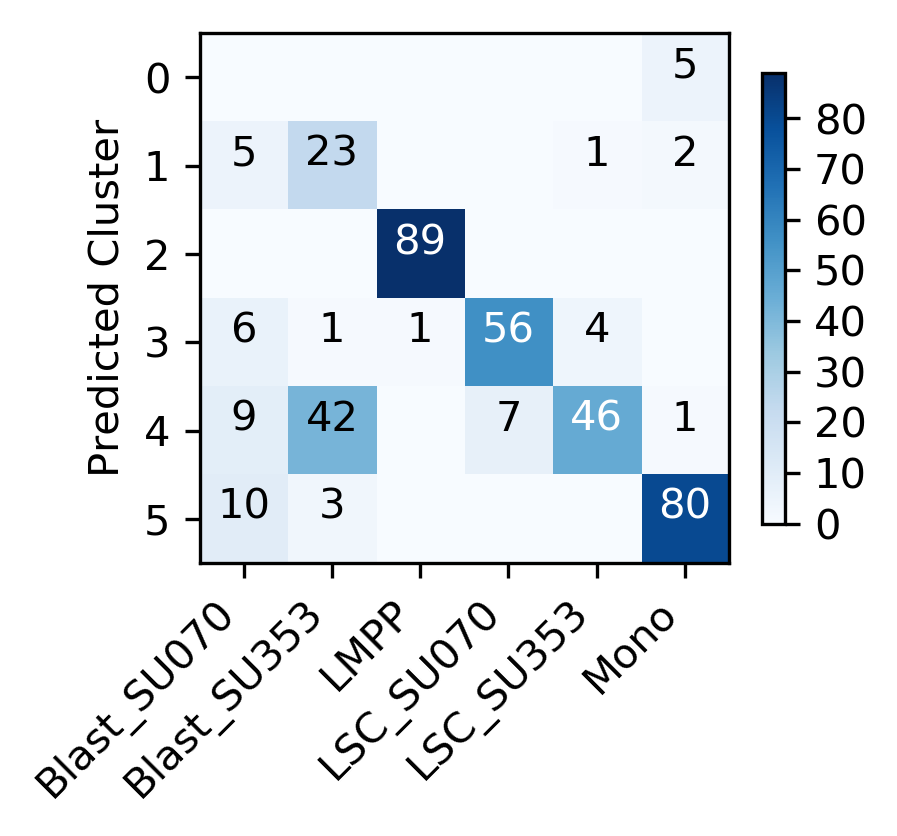

In [9]:
cm = confusion_matrix(assignments, ref)
plot_confusion_matrix(cm, classes, assign_classes, 
                    title='', normalize=False, figsize=(3,3), show_cbar=True)

## 3. Compare Impute data with raw data

####  3.1 Variances ratio of first two components of PCA 

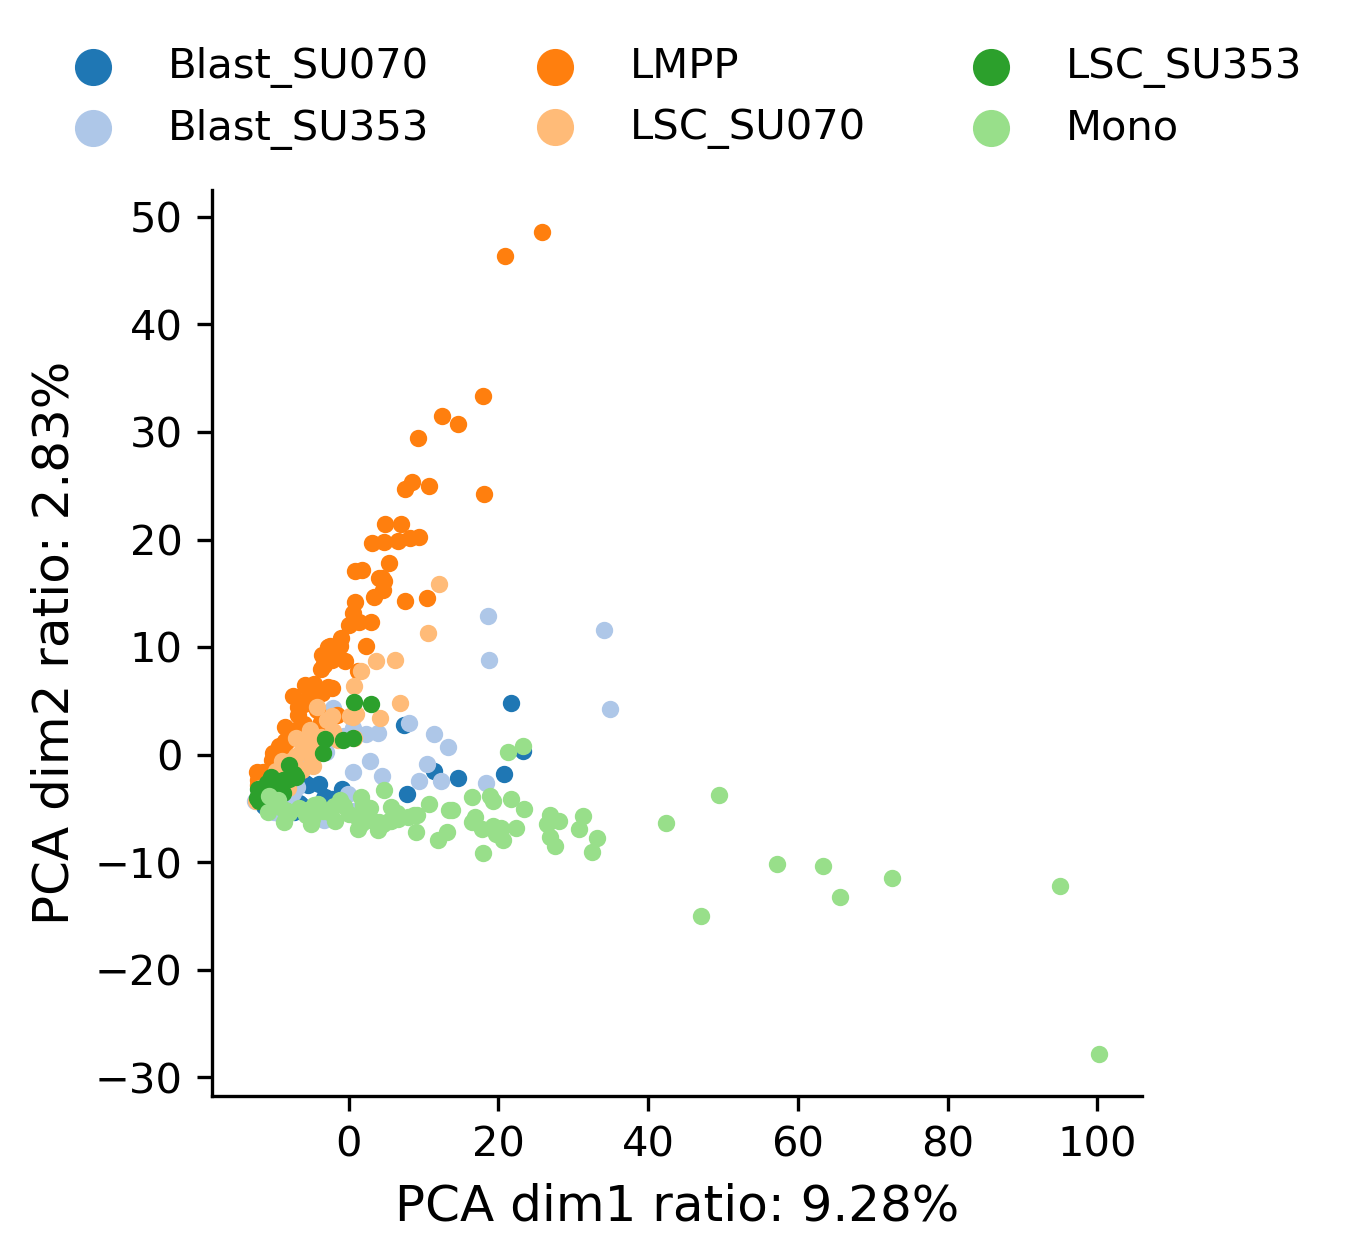

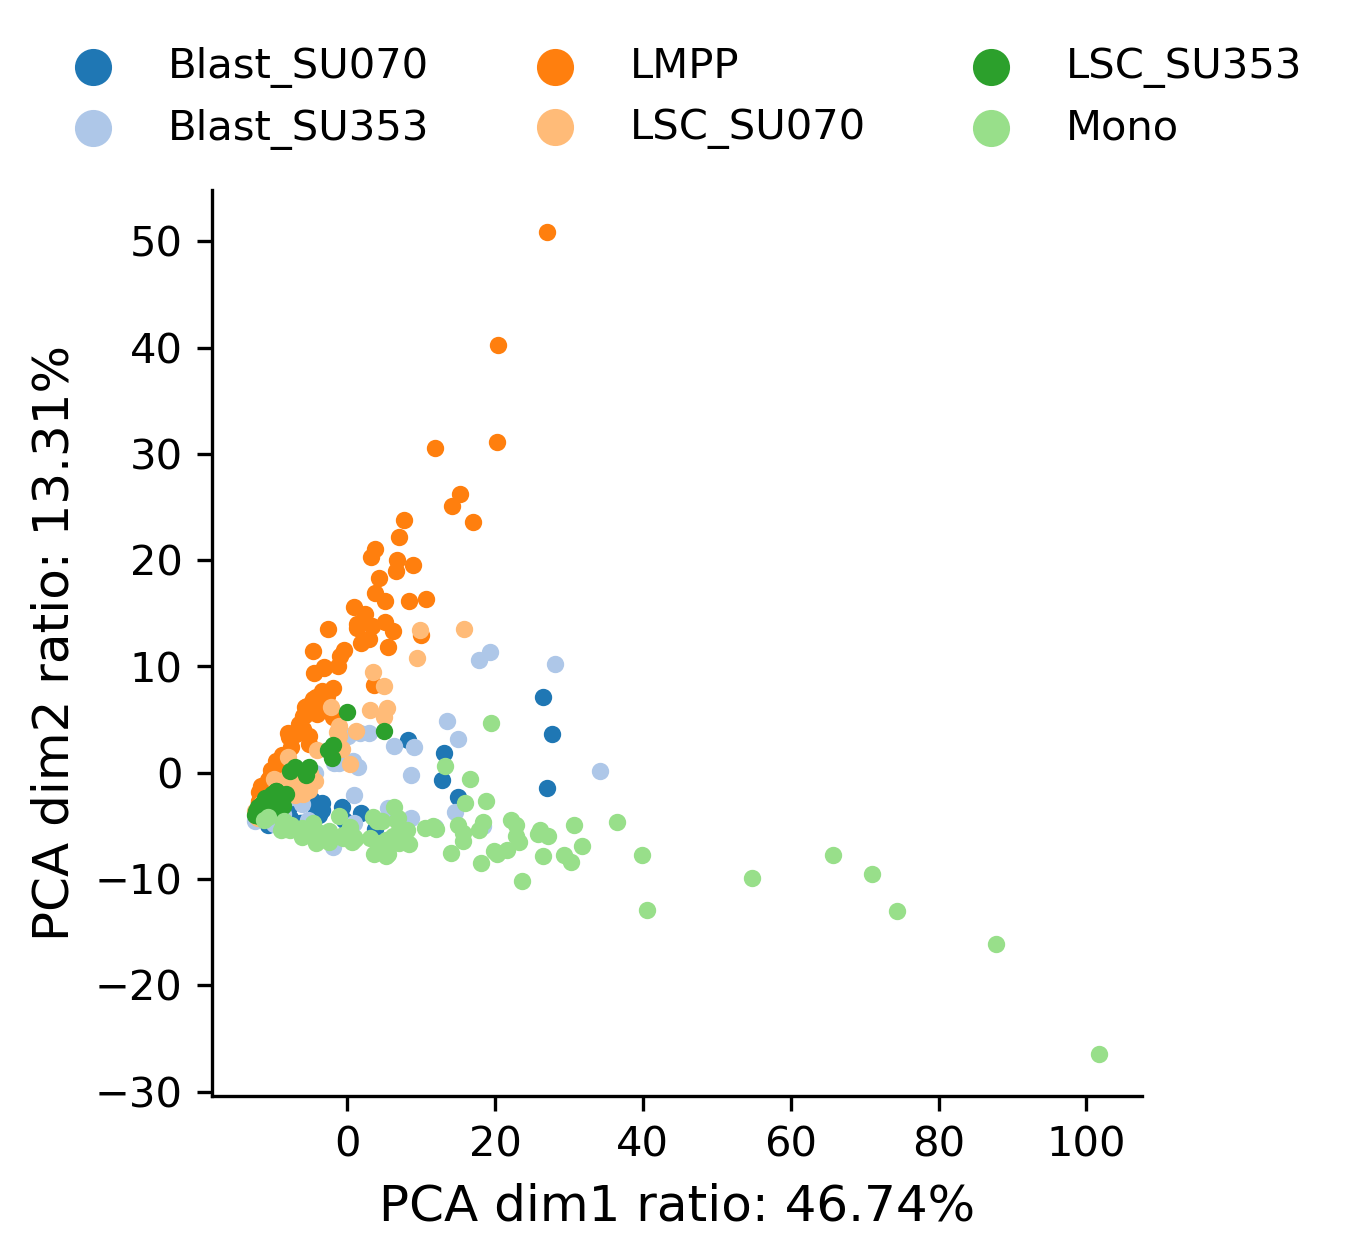

In [10]:
plot_embedding(raw_data.T, ref, classes, markersize=10, figsize=(4,4), method='PCA')
plot_embedding(imputed_data.T, ref, classes, markersize=10, figsize=(4,4), method='PCA')

#### 3.2 Cells-to-cells correlation matrix heatmap

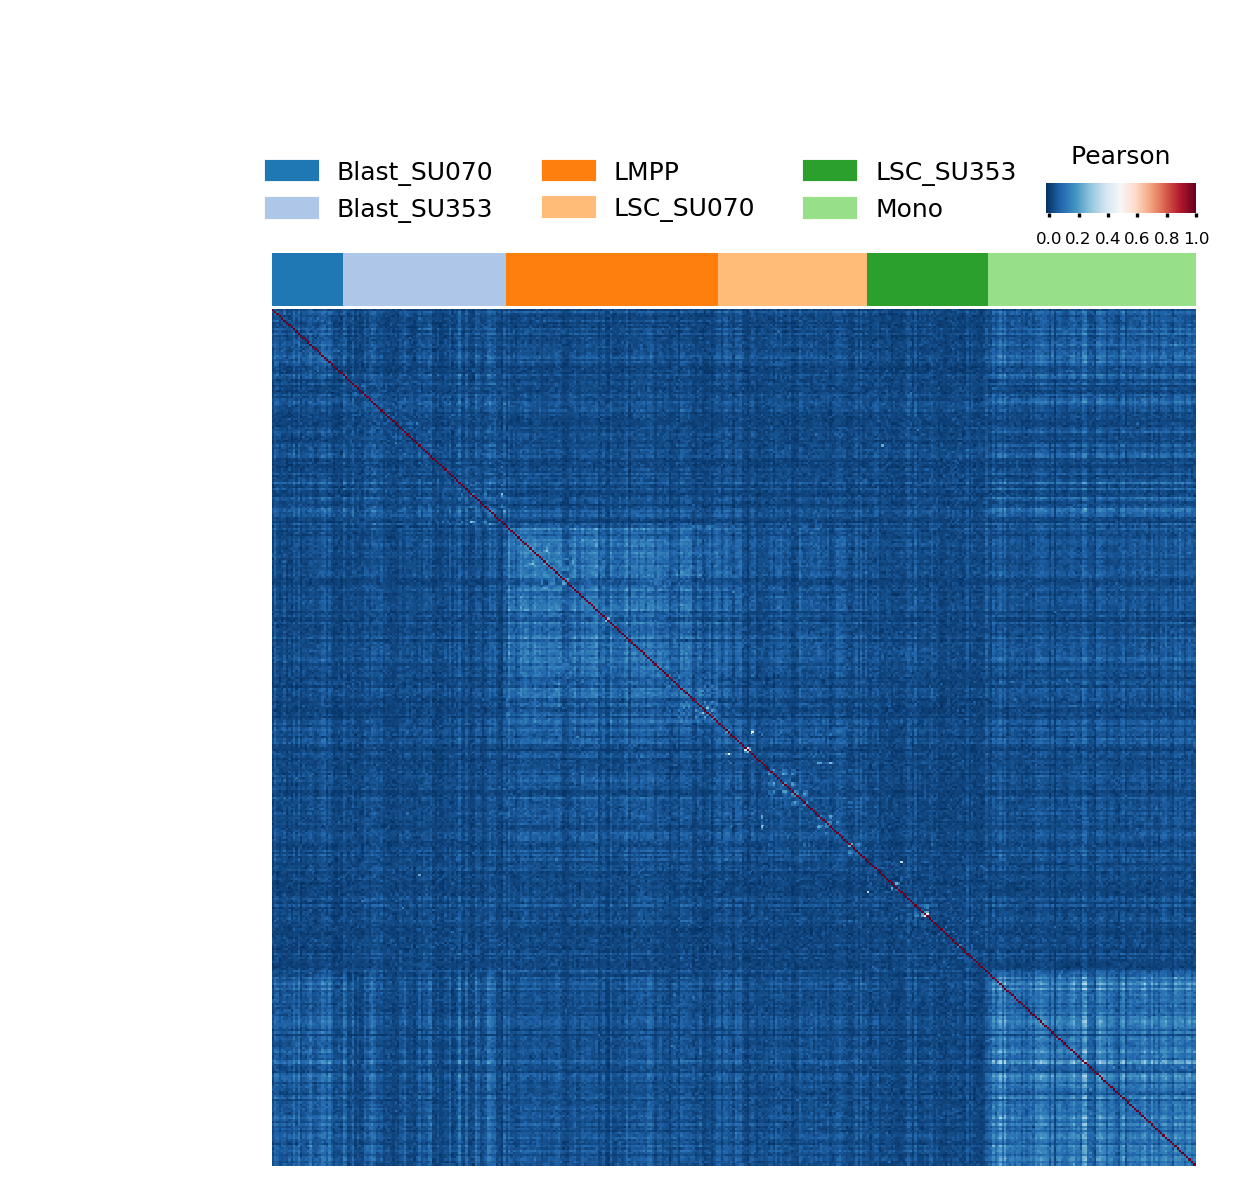

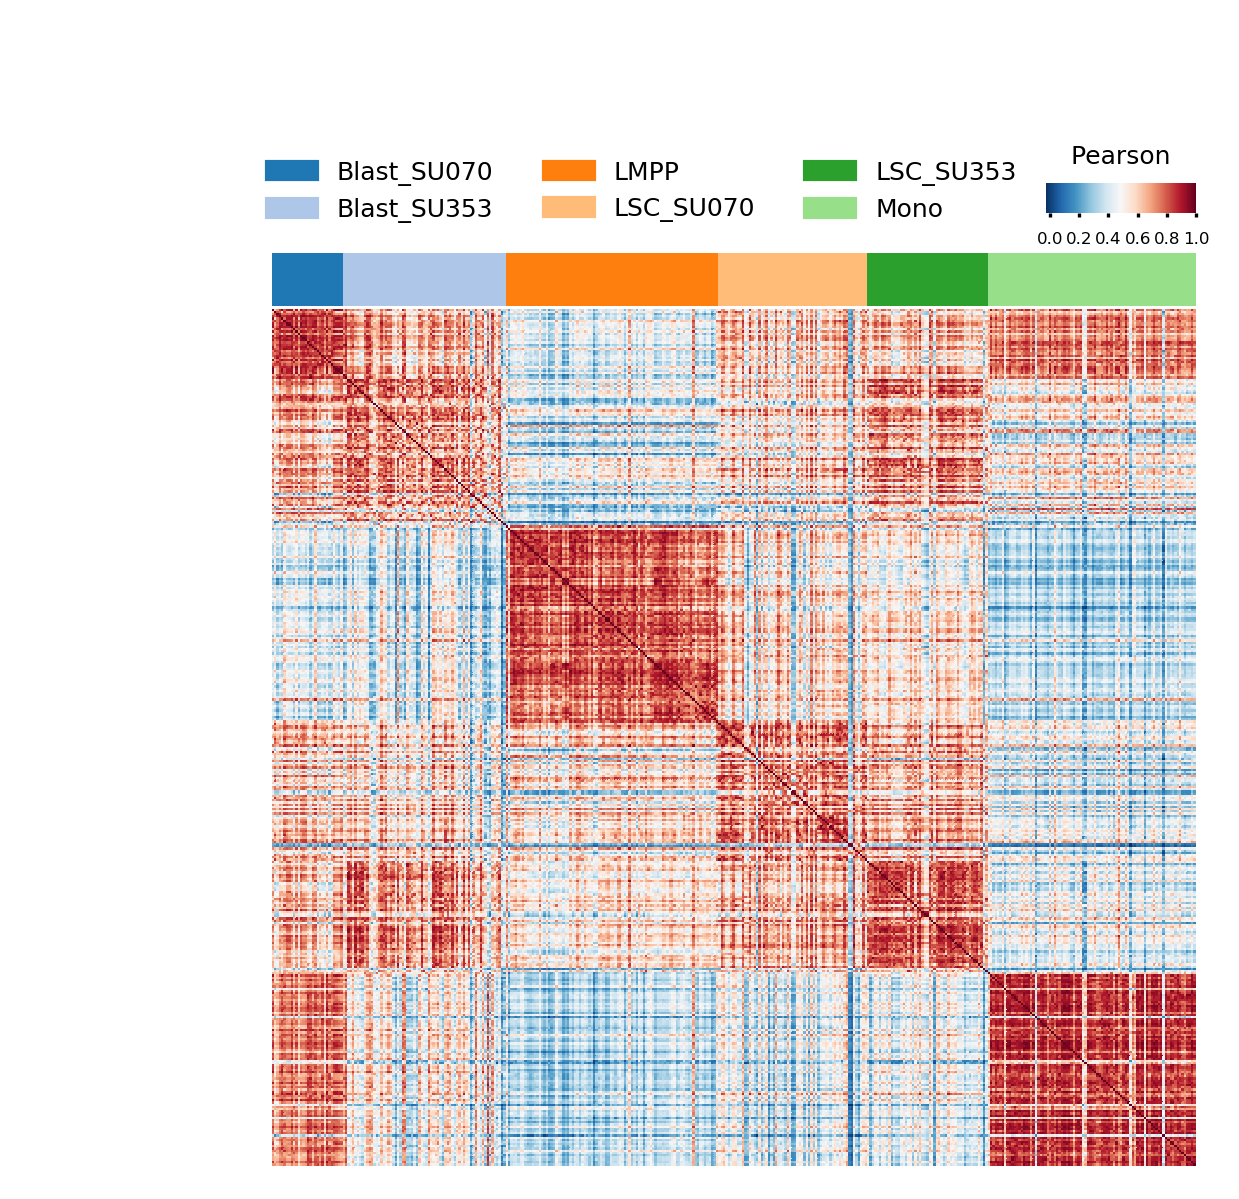

In [11]:
corr_heatmap(raw_data, ref, classes, figsize=(5,5)) 
corr_heatmap(imputed_data, ref, classes, figsize=(5,5)) 

#### 3.3 peak-to-peak correlations

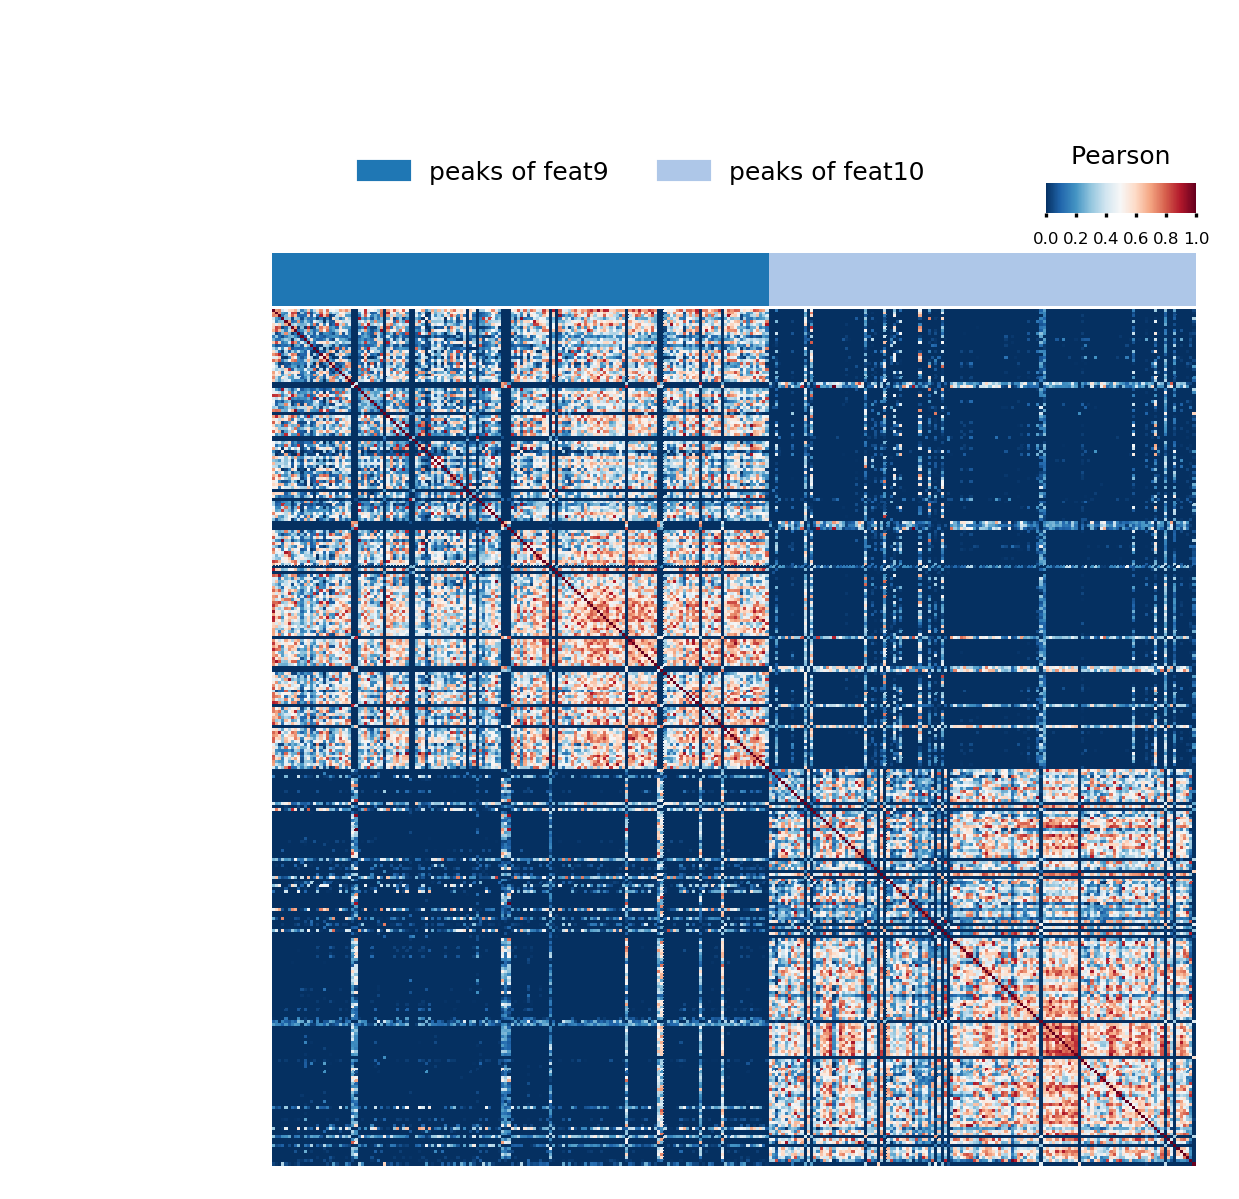

In [12]:
feats = [9, 10]
concat_peak, feat_labels = concat_specific_peak(imputed_data, specific_peak_dir, feats=feats)
corr_heatmap(concat_peak, feat_labels, ['peaks of feat'+str(feat) for feat in feats], 
                 ncol=2, vmin=0, center=0.5)

## 4. Cell type specific peaks

#### 4.1 plot feature heatmap 

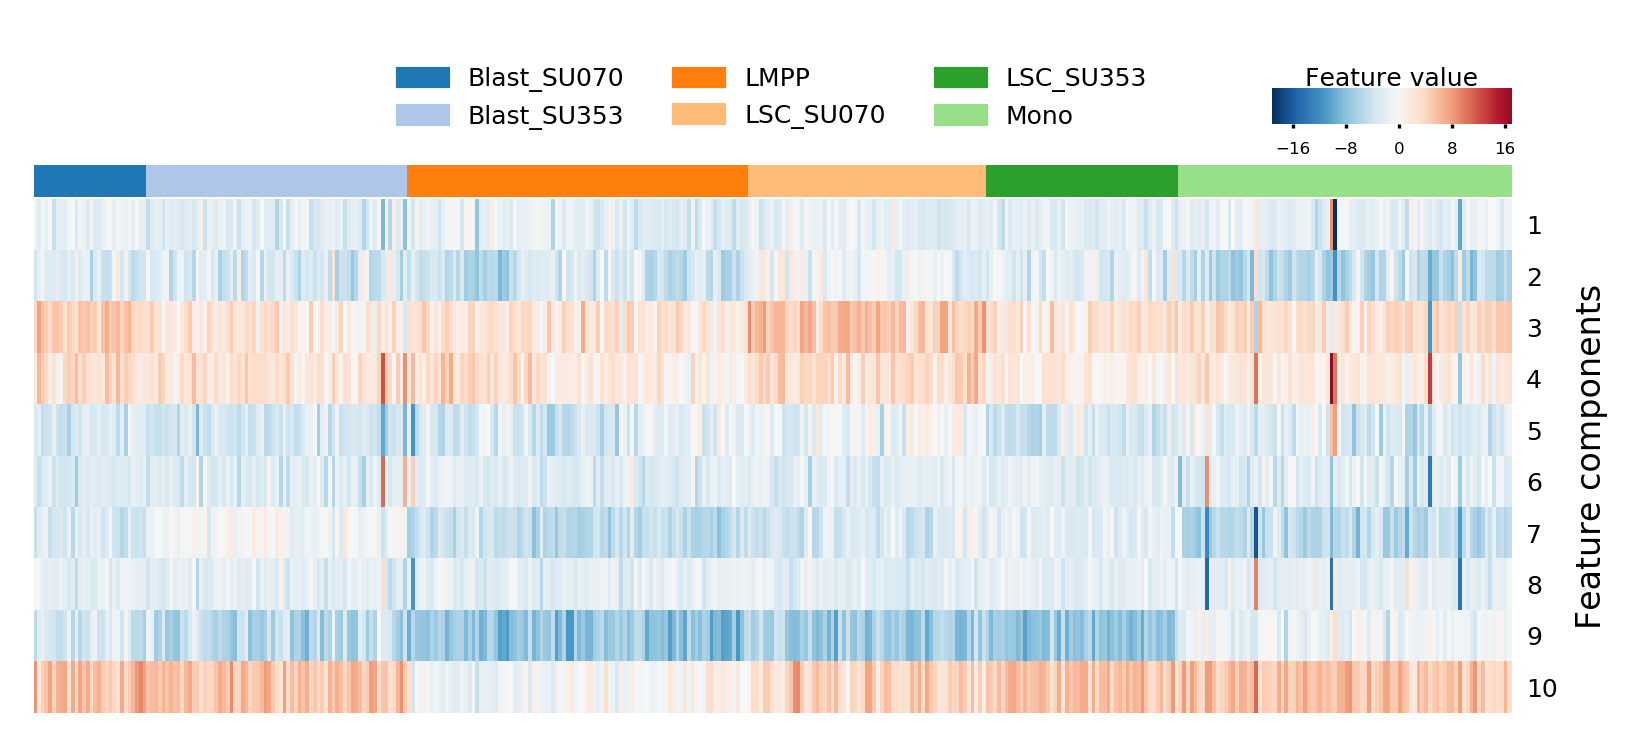

In [13]:
plot_heatmap(feature.T, ref, classes, 
             figsize=(8, 3), cmap='RdBu_r', #vmax=8, vmin=-8,
            ylabel='Feature components', yticklabels=np.arange(10)+1, 
             cax_title='Feature value',
             row_cluster=False, legend_font=6, 
             col_cluster=False, center=0)
# anova(ref, classes, feature)

#### 4.2 feature specifity

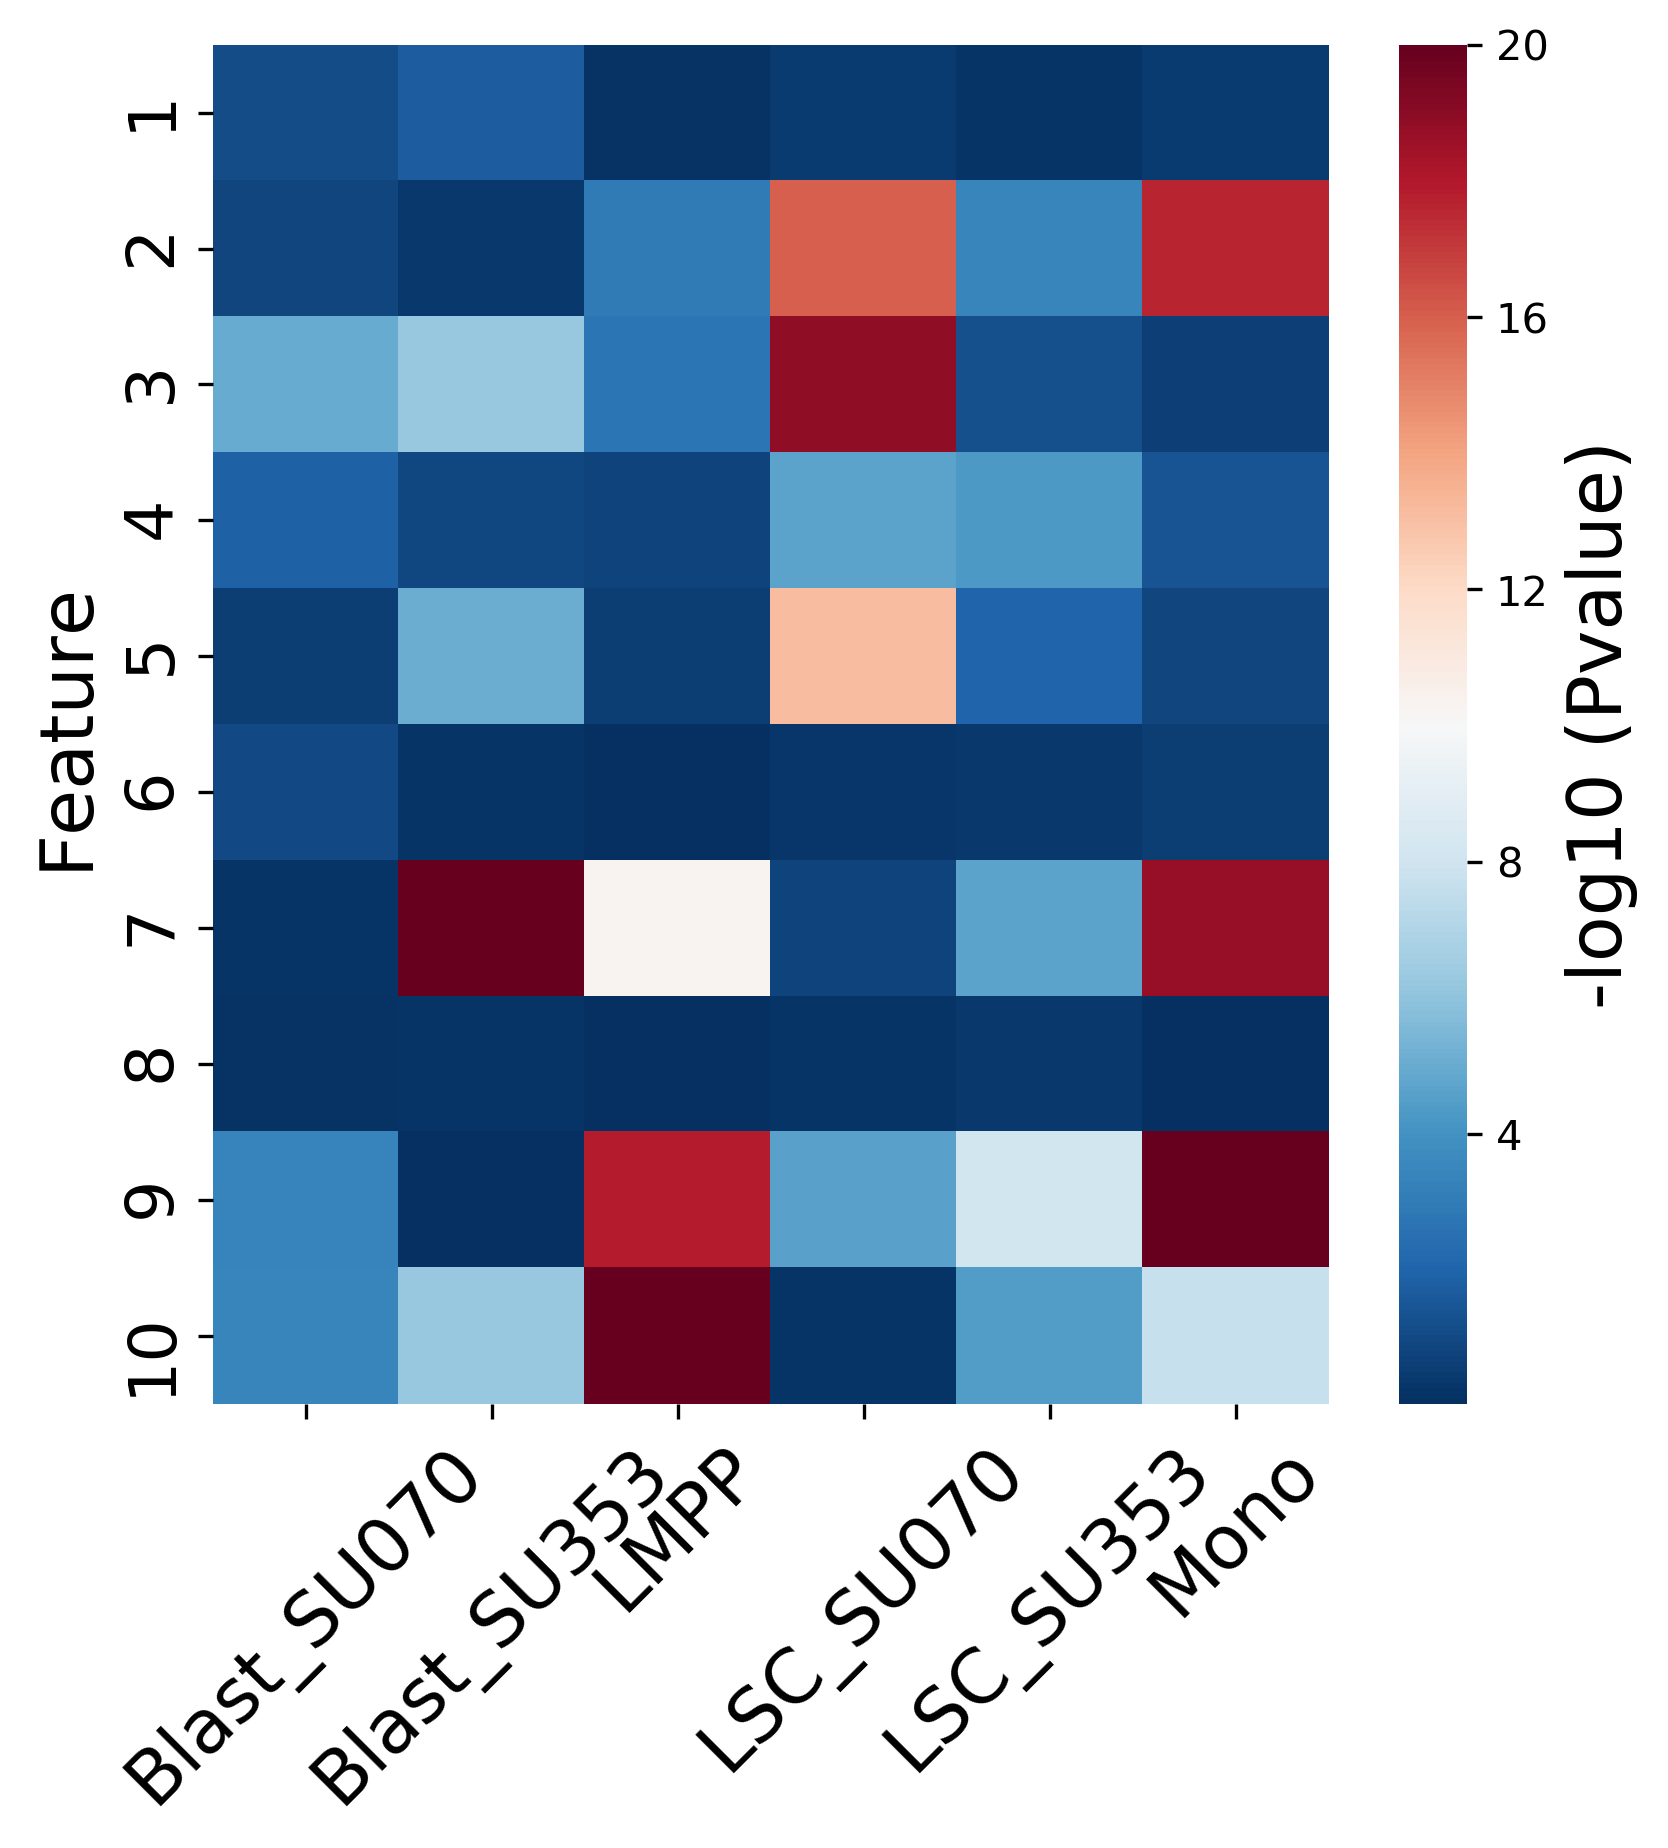

In [14]:
feature_specifity(feature, ref, classes)

#### 4.3 cell type specific peaks

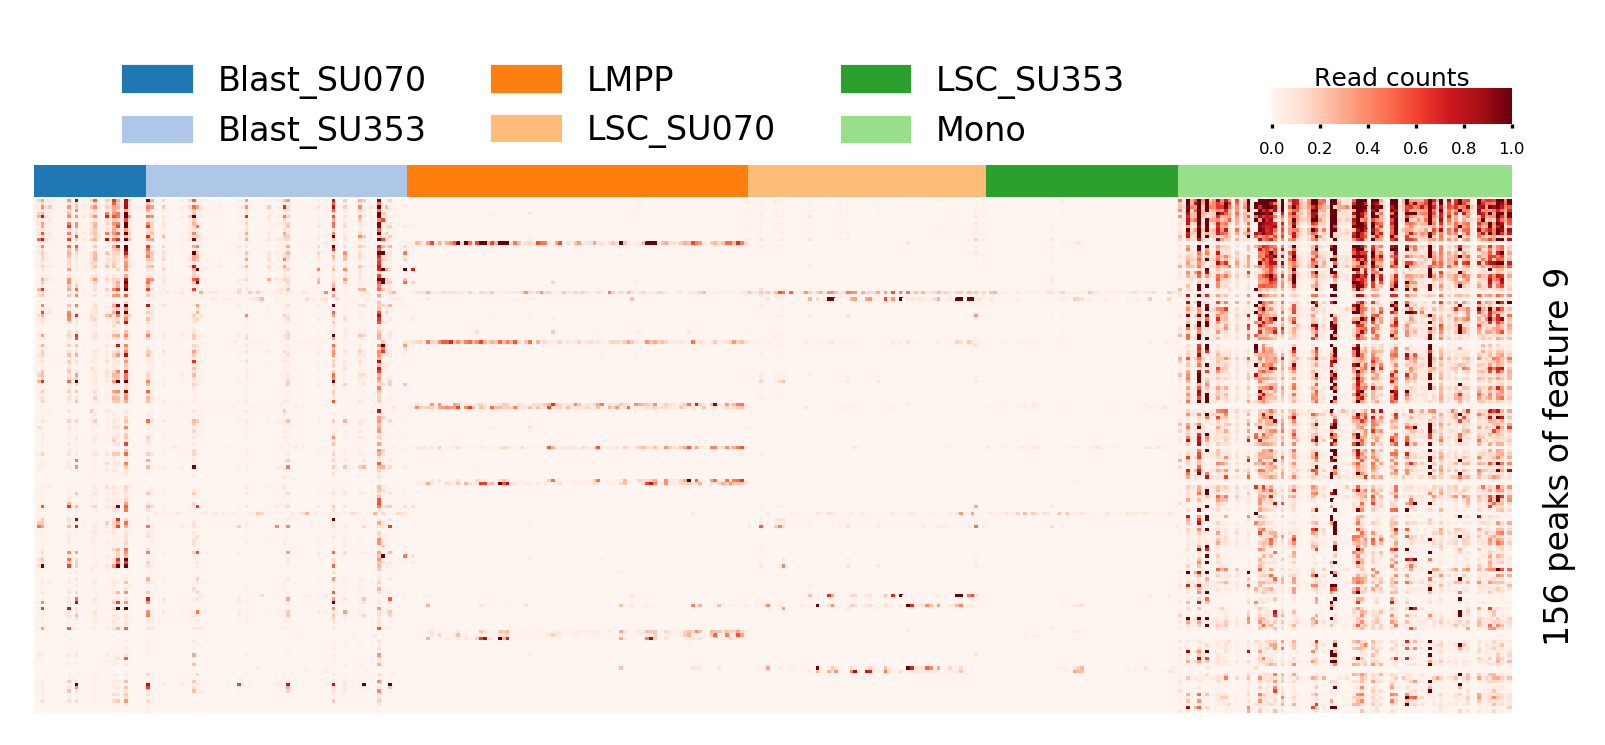

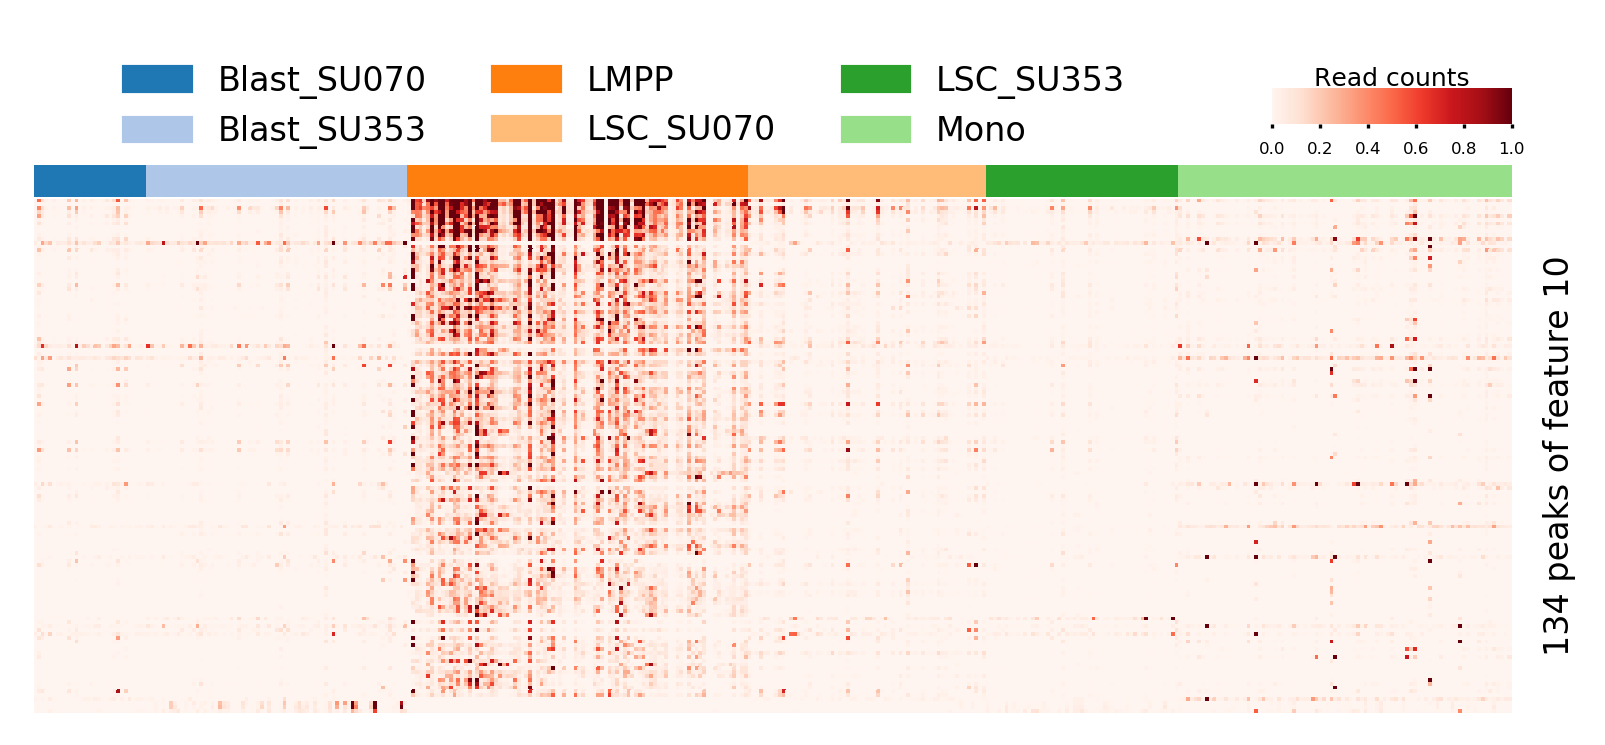

In [15]:
for i in range(feature.shape[1])[-2:]: # show the represented peaks of last two components of feature
    peak_file = specific_peak_dir+'peak_index{}.txt'.format(i)
    peak_index = open(peak_file).read().split()
    peak_data = imputed_data.loc[peak_index]
    plot_heatmap(peak_data, ref, classes,
                 cmap='Reds', 
                 figsize=(8,3), 
                 cax_title='Read counts', 
                 ylabel='{} peaks of feature {}'.format(len(peak_index), i+1),
                 vmax=1, vmin=0, legend_font=8,
                 col_cluster=False, row_cluster=False,
                 show_legend=True,
                 show_cax = True,
                 bbox_to_anchor=(0.4, 1.32),
                )

#### 4.4 cell type specific motifs with chromVAR
e.g. chromVAR -i input_dir --peakfile peak_file -o output_dir   
if -o omit, output_dir == input_dir

In [2]:
! chromVAR -i output/specific --peakfile ../data/Leukemia/peaks.txt -o output/



Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min


Attaching package: ‘S4Vectors’

The following object is masked from ‘package:base’:

    expand.grid


Attaching package: ‘Biostrings’

The following object i

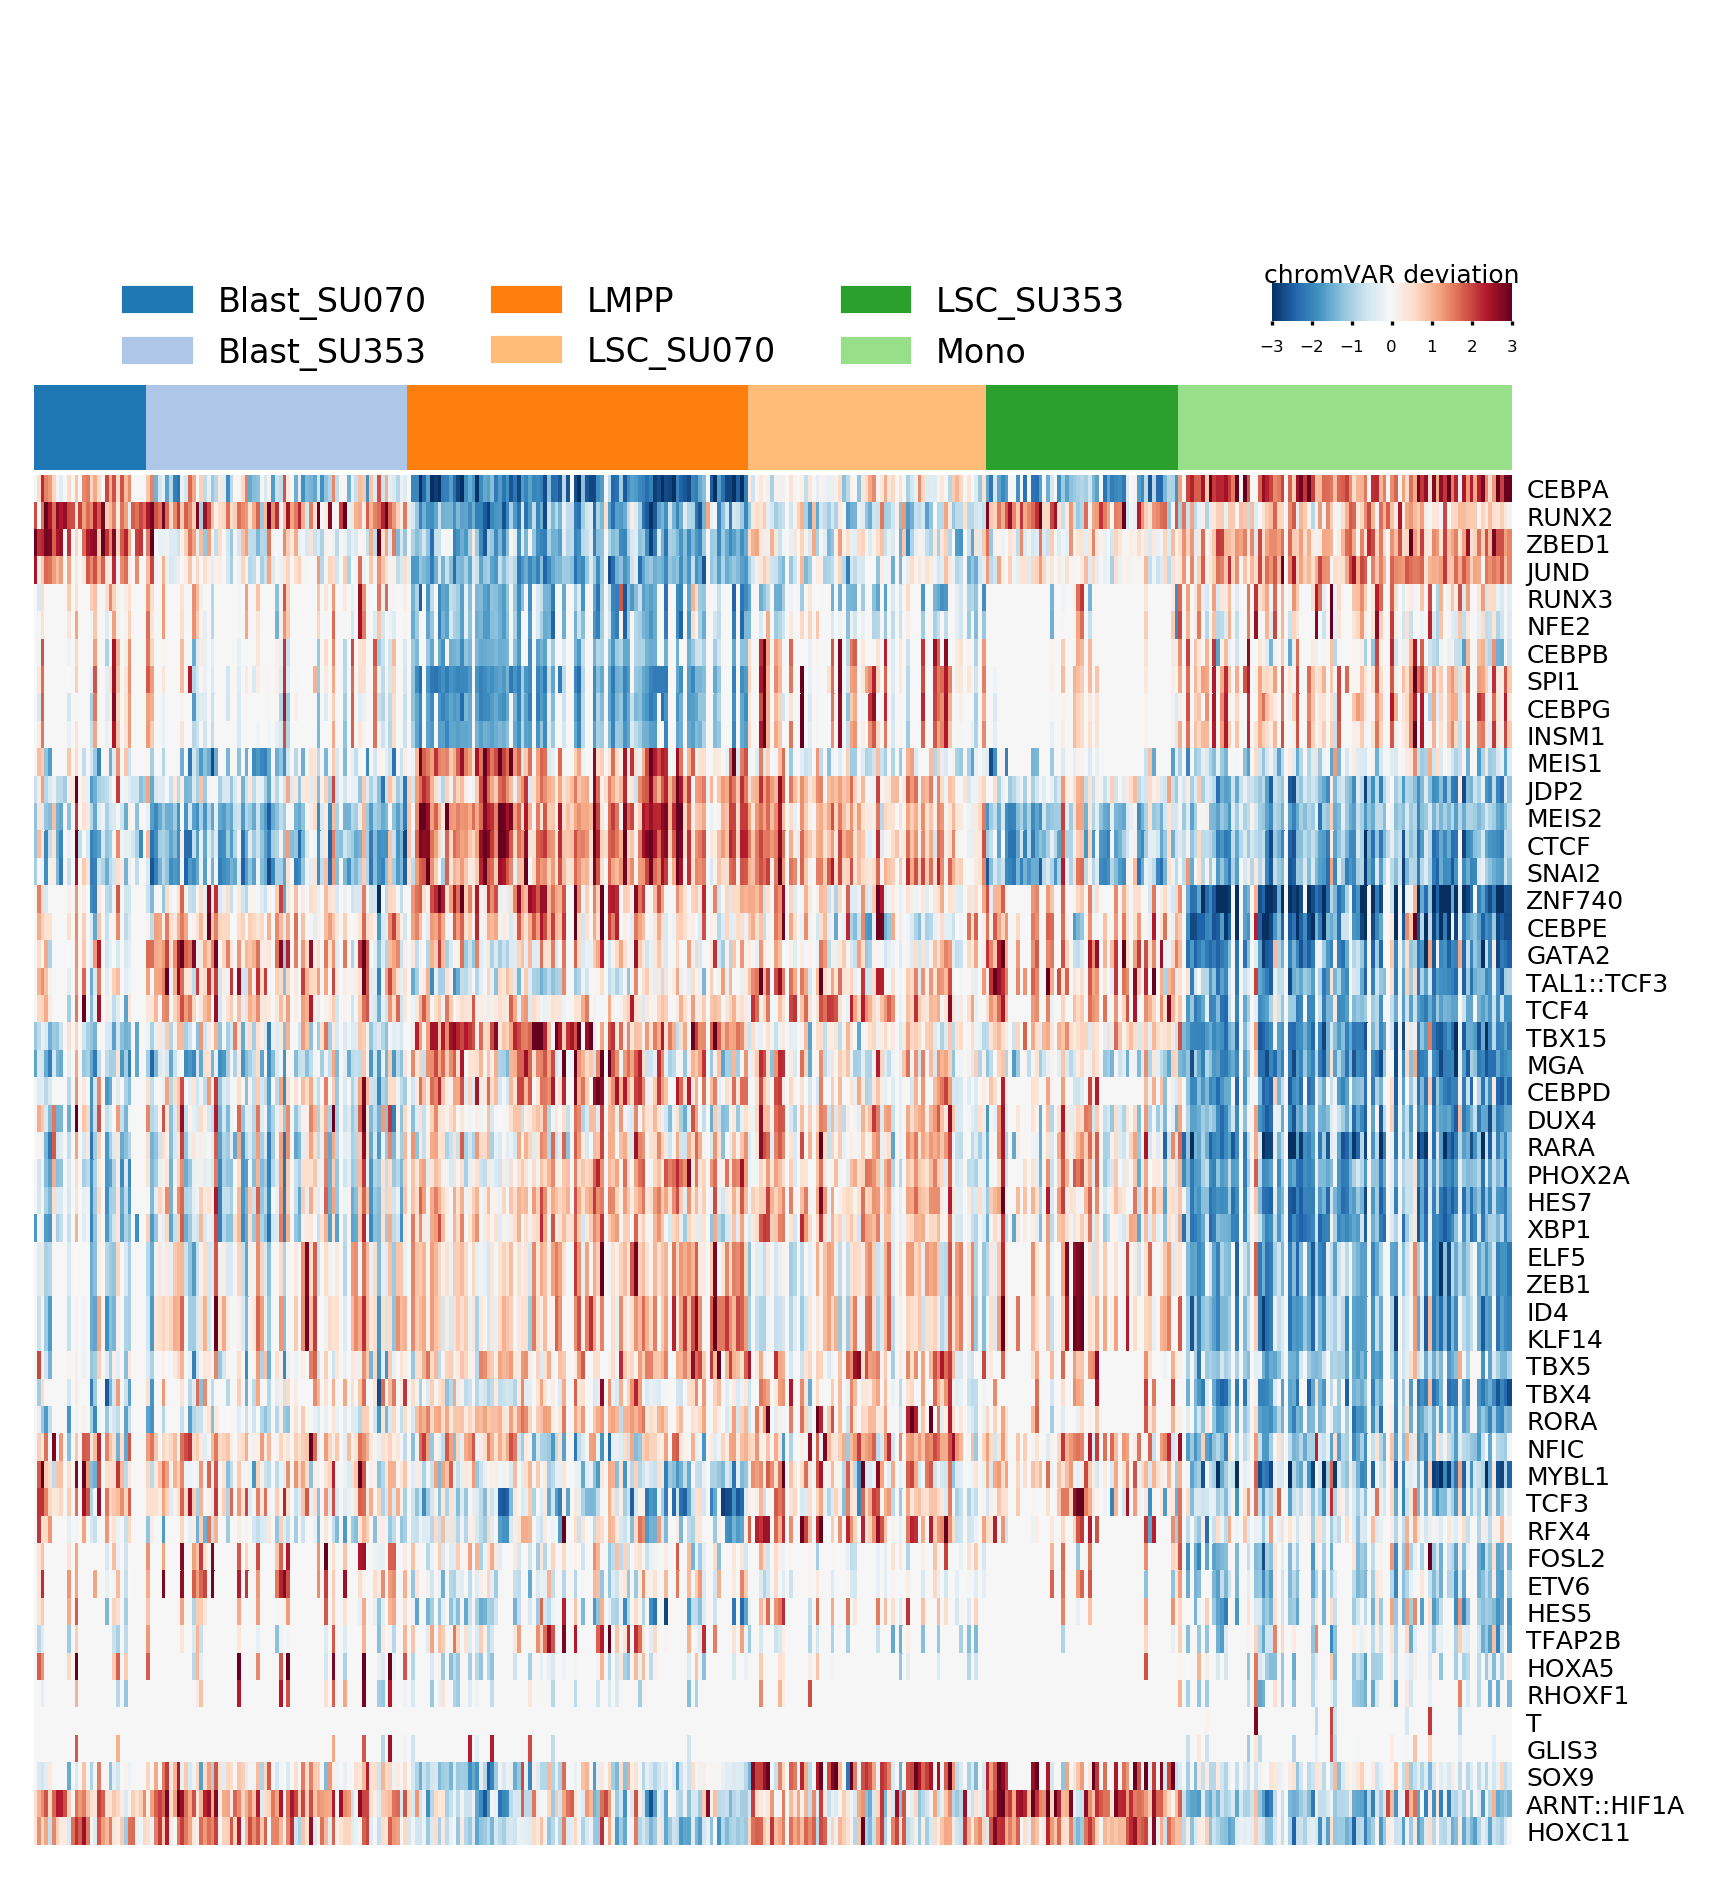

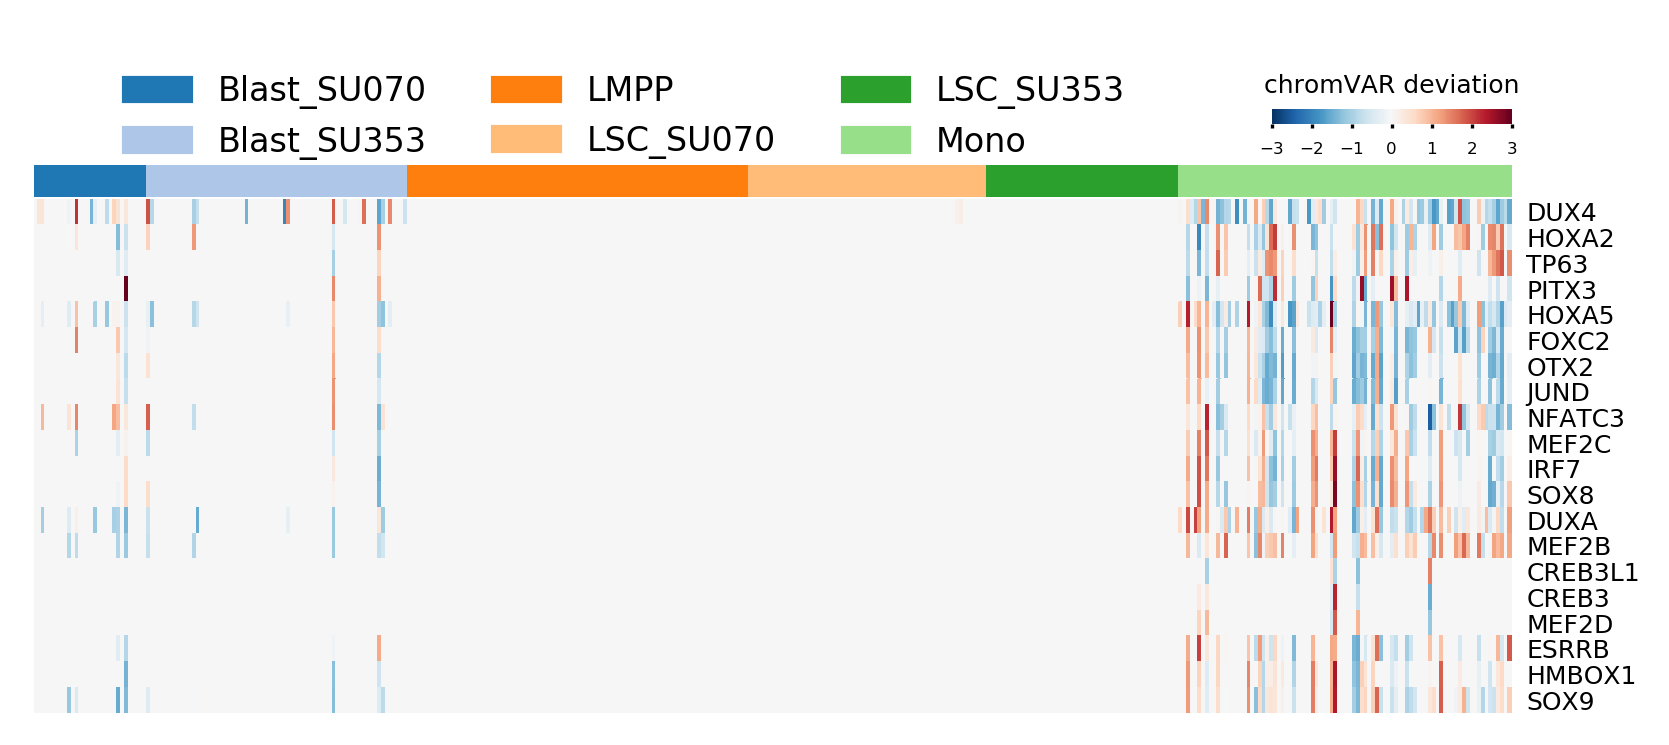

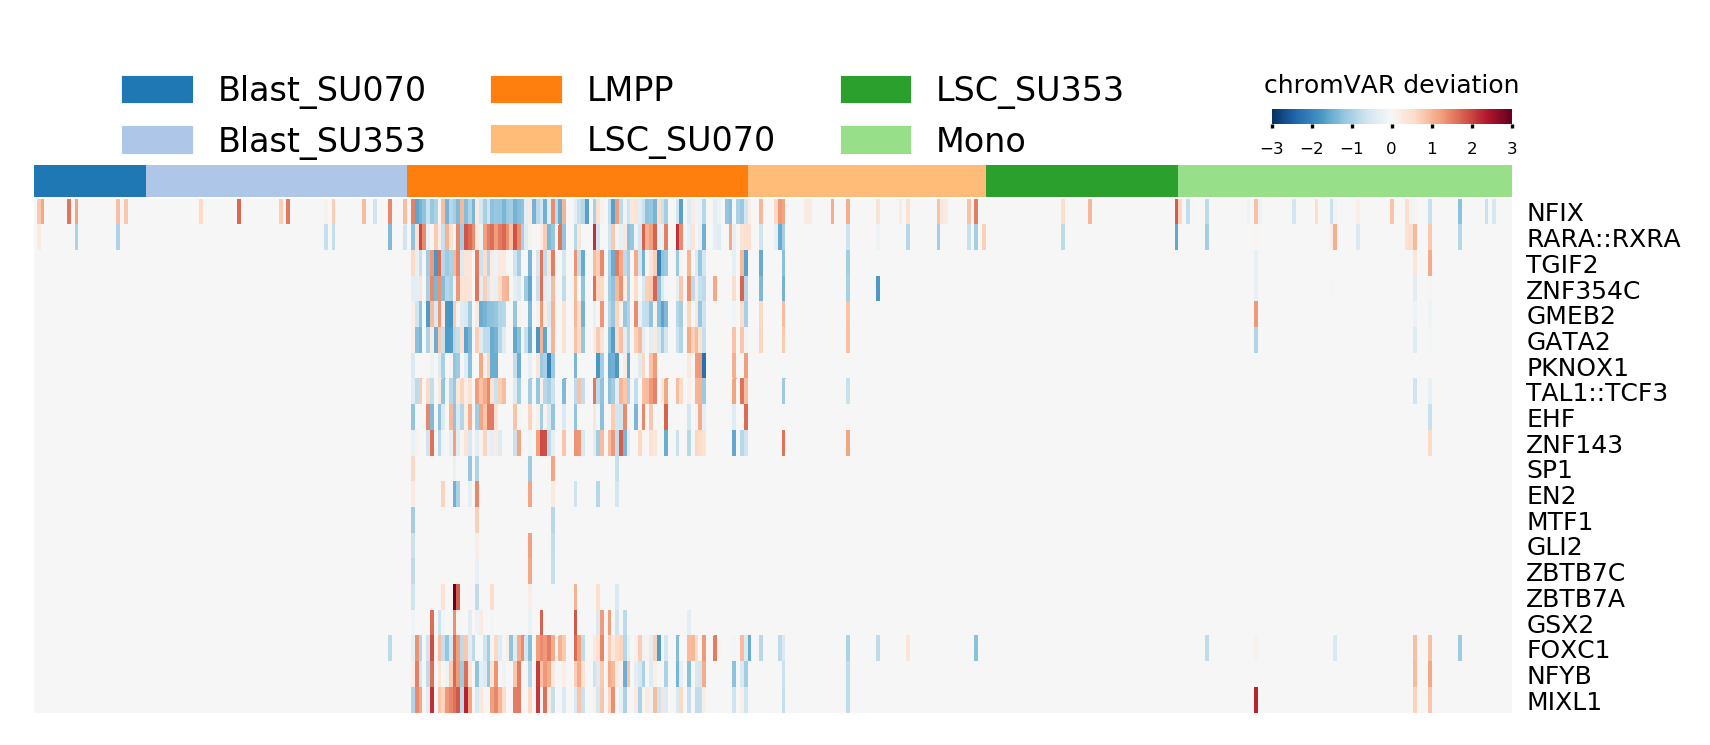

In [22]:
chromVAR_dir = out_dir+'/chromVAR'
for i in ['']+list(range(feature.shape[1]))[-2:]:
    dev = pd.read_csv(chromVAR_dir+'/dev{}'.format(i), index_col=0, sep='\t').fillna(0)
    var = pd.read_csv(chromVAR_dir+'/var{}'.format(i), index_col=0, sep='\t')
    
    if i == '':
        figsize, N, bbox_to_anchor, position = (8,8), 50, (0.4, 1.16), (0.8, 0.76, .1, .016)
    else:
        figsize, N, bbox_to_anchor, position = (8,3), 20, (0.4, 1.3), (0.8, 0.78, .1, .016)
    index = var.sort_values(by='variability', ascending=False).index[:N]
    yticklabels = var.loc[index].name.values
    plot_heatmap(dev.loc[index], ref, classes, 
                 row_cluster=True, 
                 col_cluster=False, 
                 metric='Euclidean',
                 yticklabels=yticklabels, 
                 vmax=3, vmin=-3, 
                 figsize=figsize, 
                 legend_font=8,
                 show_legend=True,
                 show_cax=True,
                 bbox_to_anchor=bbox_to_anchor,
                 position=position,
                 tick_color='black',
                 cax_title='chromVAR deviation',
                 cmap='RdBu_r')